In [21]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
xray_directory = 'Dataset/'

In [ ]:
os.listdir(xray_directory)

In [ ]:
image_generator = ImageDataGenerator(rescale = 1. / 255)

In [ ]:
train_generator = image_generator.flow_from_directory(
    batch_size = 40,
    directory = xray_directory,
    shuffle = True,
    target_size = (256, 256),
    class_mode = 'categorical',
    subset = 'training'
)

In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

In [ ]:
train_labels

In [ ]:
labels_name = {0: 'Covid-19',
               1: 'Normal',
               2: 'Pneumonia Viral',
               3: 'Pneumonia Bacteriana'}

In [ ]:
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
ax = ax.ravel()
for i in np.arange(0, 36):
    ax[i].imshow(train_images[i])
    ax[i].set_title(labels_name[np.argmax(train_labels[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace = 0.5)

In [ ]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [ ]:
base_model.summary()

In [ ]:
len(base_model.layers)

In [ ]:
for layer in base_model.layers[:-10]:
    layers.trainable = False

In [ ]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [ ]:
model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.RMSprop(
        learning_rate = 1e-4,
        decay = 1e-6
    ),
    metrics = ['accuracy']
)

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5')

In [ ]:
train_generator = image_generator.flow_from_directory(
    batch_size = 4,
    directory = xray_directory,
    shuffle = True,
    target_size = (256, 256),
    class_mode = 'categorical',
    subset = 'training'
)

In [ ]:
history = model.fit(train_generator, epochs = 2, callbacks = [checkpointer])

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro'])

In [ ]:
test_directory = 'Test/'

In [ ]:
os.listdir(test_directory)

In [ ]:
test_gen = ImageDataGenerator(rescale = 1. / 255)
test_generator = test_gen.flow_from_directory(
    batch_size = 40,
    directory = test_directory,
    shuffle = True,
    target_size  = (256, 256),
    class_mode = 'categorical'
)

In [ ]:
evaluate = model.evaluate(test_generator)

In [ ]:
evaluate

In [ ]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

In [ ]:
print(prediction)

In [ ]:
print(original)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
accuracy_score(original, prediction)

In [ ]:
fig, ax = plt.subplots(5, 6, figsize = (12, 12))
ax = ax.ravel()
for i in np.arange(0, 30):
    ax[i].imshow(image[i])
    ax[i].set_title('Previsão: {}\nReal: {}'.format(str(labels_name[prediction[i]]), str(labels_name[original[i]])))
    ax[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

# Análise

In [ ]:
cm = confusion_matrix(original, prediction)

In [ ]:
sns.heatmap(cm, annot = True)

In [ ]:
print(classification_report(original, prediction))

# Simulação

In [22]:
from keras.models import load_model
model_loaded = load_model('weights.hdf5')

In [23]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

conv4_block2_3_conv (Conv2D)    (None, 16, 16, 1024) 263168      conv4_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_3_bn (BatchNormali (None, 16, 16, 1024) 4096        conv4_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_add (Add)          (None, 16, 16, 1024) 0           conv4_block1_out[0][0]           
                                                                 conv4_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_out (Activation)   (None, 16, 16, 1024) 0           conv4_block2_add[0][0]           
__________________________________________________________________________________________________
conv4_block3_1_conv (Conv2D)    (None, 16, 16, 256)  262400      conv4_block2_out[0][0]           
__________

In [24]:
img = cv2.imread('Test/0/radiol.2020200490.fig3.jpeg')

In [25]:
print(img)

[[[192 192 192]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [134 134 134]]

 [[192 192 192]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [134 134 134]]

 [[192 192 192]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [134 134 134]]

 ...

 [[196 196 196]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  3   3   3]
  [134 134 134]]

 [[187 187 187]
  [  5   5   5]
  [  0   0   0]
  ...
  [  0   0   0]
  [  7   7   7]
  [129 129 129]]

 [[214 214 214]
  [ 80  80  80]
  [ 87  87  87]
  ...
  [ 80  80  80]
  [ 84  84  84]
  [181 181 181]]]


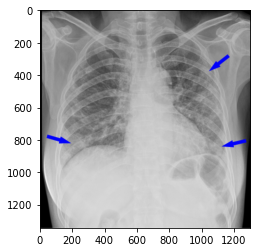

In [27]:
plt.imshow(img)